https://bioinformatics.stackexchange.com/questions/10594/what-do-the-symbols-mean-in-minimap2s-gap-cost-equation

/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit/experiments/optimized_for_DELs/minSVSize/data/minSVSize=50/truvari-INS-pacbio-trfermikit


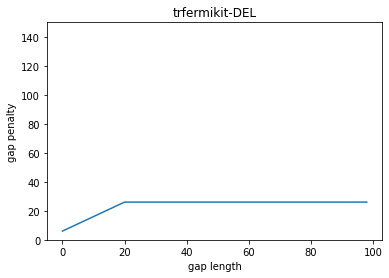

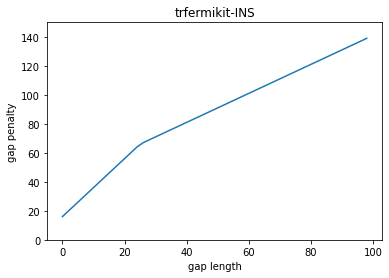

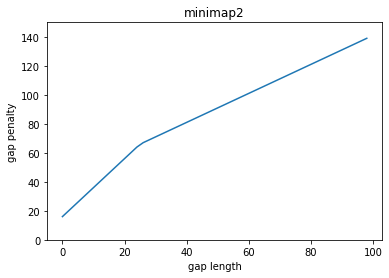

In [9]:
import numpy as np 

def get_alignment_parameters(tool): 
    if tool == 'trfermikit-DEL': 
        return { 
            'singleBaseMatchReward': '10',
            'singleBaseMismatchPenalty': '12',
            'gapOpenPenalties': '6,26',
            'gapExtensionPenalties': '1,0'
        }        
    if tool == 'trfermikit-INS': 
        return { 
            'singleBaseMatchReward': '10',
            'singleBaseMismatchPenalty': '12',
            'gapOpenPenalties': '16,41',
            'gapExtensionPenalties': '2,1'
        }        
    if tool == 'minimap2': 
        # asm10
        return { 
            'singleBaseMatchReward': '1',
            'singleBaseMismatchPenalty': '9',
            'gapOpenPenalties': '16,41',
            'gapExtensionPenalties': '2,1'
        }
    print('not valid tool')
    raise Exception
            
def get_gap_penalty(length, tool):
    gap_open_penalty_1, gap_open_penalty_2 = map(int, get_alignment_parameters(tool)['gapOpenPenalties'].split(','))
    gap_extension_penalty_1, gap_extension_penalty_2 = map(int, get_alignment_parameters(tool)['gapExtensionPenalties'].split(','))
    
    if gap_extension_penalty_1 < gap_extension_penalty_2: raise Exception 
    if gap_open_penalty_1 + gap_extension_penalty_1 > gap_open_penalty_2 + gap_extension_penalty_2: raise Exception 

    return min([
        gap_open_penalty_1 + abs(length)*gap_extension_penalty_1, 
        gap_open_penalty_2 + abs(length)*gap_extension_penalty_2
    ])

def plot_gap_penalty(tool): 
    lengths = np.arange(0, 100, 2)

    gap_penalties = [] 
    for length in lengths: gap_penalties.append(get_gap_penalty(length, tool))

    import matplotlib.pyplot as plt 

    plt.plot(lengths, gap_penalties)
    plt.title(tool)
    plt.xlabel('gap length')
    plt.ylabel('gap penalty')
    plt.ylim(bottom=0)
    plt.ylim(top=150)
    plt.show() 
    
plot_gap_penalty('trfermikit-DEL')
plot_gap_penalty('trfermikit-INS')
plot_gap_penalty('minimap2')

In [10]:
def parse_cigar(cigar): 
    import re
    # \d+ matches any number of digits
    # [] indicates a set of characters
    # {1} specifies that exactly 1 copy of the previous RE should be matched
    # (...) matches whatever regular expression is inside the parentheses, and indicates the start and end of a group
    # r means the string will be treated as raw string
    return re.findall(r'(\d+)([A-Z]{1})', cigar)
    
def get_gap_lengths(cigar):
    gap_lengths = []
    for length, op in parse_cigar(cigar): 
        if op == 'I' or op == 'D': gap_lengths.append(int(length))
    return gap_lengths
            
def get_number_Ms(cigar):
    number_Ms = 0
    for length, op in parse_cigar(cigar): 
        if op == 'M': number_Ms += int(length)
    return number_Ms

def get_match_reward(length, tool): 
    return length*int(get_alignment_parameters(tool)['singleBaseMatchReward'])
    
def get_mismatch_reward(length, tool): 
    return length*int(get_alignment_parameters(tool)['singleBaseMismatchPenalty'])
    
def get_alignment_score(cigar, edit_distance, name, tool):    
    # AS:i:score ... Alignment score generated by aligner
    # NM:i:count ... "Edit Distance" = Number of differences (mismatches plus inserted and deleted bases) between the sequence and reference
    # [https://samtools.github.io/hts-specs/SAMtags.pdf]
    gap_penalty = 0
    number_gapped_basepairs = 0
    for length in get_gap_lengths(cigar): 
        gap_penalty += get_gap_penalty(length, tool)
        number_gapped_basepairs += length        
    number_mismatched_basepairs = edit_distance - number_gapped_basepairs
    number_matched_basepairs = get_number_Ms(cigar) - number_mismatched_basepairs
    alignment_score = ( 
        get_match_reward(number_matched_basepairs, tool) 
        - get_mismatch_reward(number_mismatched_basepairs, tool)
        - gap_penalty
    )
    print('{}; tool = {}; alignment_score = {}'.format(name, tool, alignment_score))

def get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS):
    get_alignment_score(cigar=cigar_DEL, edit_distance=edit_distance_DEL, name='DEL alignment', tool='trfermikit-DEL')
    get_alignment_score(cigar=cigar_INS, edit_distance=edit_distance_INS, name='INS alignment', tool='trfermikit-DEL')    
    print()
    get_alignment_score(cigar=cigar_DEL, edit_distance=edit_distance_DEL, name='DEL alignment', tool='trfermikit-INS')
    get_alignment_score(cigar=cigar_INS, edit_distance=edit_distance_INS, name='INS alignment', tool='trfermikit-INS')    
    print()
    get_alignment_score(cigar=cigar_DEL, edit_distance=edit_distance_DEL, name='DEL alignment', tool='minimap2')
    get_alignment_score(cigar=cigar_INS, edit_distance=edit_distance_INS, name='INS alignment', tool='minimap2')

def locus1():
    comment = 'this locus is really an INS supported by soft-clipping'
    read_name = '288901588:176512244'
    locus = 'chr2:226485667-226486268'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '11M6D5M240D8M1D15M122D251M'
    edit_distance_DEL = 369
    cigar_INS = '251M'
    edit_distance_INS = 0
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus1() 

this locus is really an INS supported by soft-clipping
Read name: 288901588:176512244
Locus: chr2:226485667-226486268
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 2829
INS alignment; tool = trfermikit-DEL; alignment_score = 2510

DEL alignment; tool = trfermikit-INS; alignment_score = 2410
INS alignment; tool = trfermikit-INS; alignment_score = 2510

DEL alignment; tool = minimap2; alignment_score = -200
INS alignment; tool = minimap2; alignment_score = 251


In [11]:
def locus2():
    comment = 'truth: INS supported by gapped alignment'
    read_name = '3265768:275673537'
    locus = 'chr1:230588541-230589142'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '8M4D25M100D37M197D428M'
    edit_distance_DEL = 302
    cigar_INS = '11M59I428M'
    edit_distance_INS = 59
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus2() 

truth: INS supported by gapped alignment
Read name: 3265768:275673537
Locus: chr1:230588541-230589142
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 4896
INS alignment; tool = trfermikit-DEL; alignment_score = 4364

DEL alignment; tool = trfermikit-INS; alignment_score = 4555
INS alignment; tool = trfermikit-INS; alignment_score = 4290

DEL alignment; tool = minimap2; alignment_score = 85
INS alignment; tool = minimap2; alignment_score = 339


In [14]:
def locus3():
    comment = 'truth: INS supported by soft clipping'
    read_name = '76156255:120068149'
    locus = 'chr5:162906548-162907149'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '7M2I1D1M1D110M30D4M1I6M'
    edit_distance_DEL = 35
    cigar_INS = '7M2I1D1M1D110M'
    edit_distance_INS = 4
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus3() 

truth: INS supported by soft clipping
Read name: 76156255:120068149
Locus: chr5:162906548-162907149
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 1225
INS alignment; tool = trfermikit-DEL; alignment_score = 1158

DEL alignment; tool = trfermikit-INS; alignment_score = 1135
INS alignment; tool = trfermikit-INS; alignment_score = 1124

DEL alignment; tool = minimap2; alignment_score = -17
INS alignment; tool = minimap2; alignment_score = 62
